In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.price_forcasting import *

In [4]:
# load the dataset 
df=pd.read_csv('../data/price_with_features.csv')

In [5]:
df.head()

,Date,Price,Returns,Volatility,MA_50,MA_200,Momentum,Log_Returns
0,1988-03-01,14.18,-0.037339,0.015044,16.2580,18.05060,-0.123609,-0.038054
1,1988-03-02,13.80,-0.026798,0.014953,16.2334,18.02645,-0.145511,-0.027164
2,1988-03-03,14.00,0.014493,0.015357,16.2014,18.00420,-0.134734,0.014389
3,1988-03-04,14.00,0.000000,0.014894,16.1734,17.98145,-0.130435,0.000000
4,1988-03-07,13.90,-0.007143,0.014595,16.1174,17.95795,-0.157576,-0.007168


In [6]:
analyzer = OilPriceAnalysis(df)
analyzer.prepare_data(test_size=0.2)  # Using 20% of data for testing

Fitting ARIMA model...
ARIMA metrics: {'rmse': np.float64(33.4536381368727), 'mae': np.float64(27.347140054170637), 'r2': -1.6207139790070535}


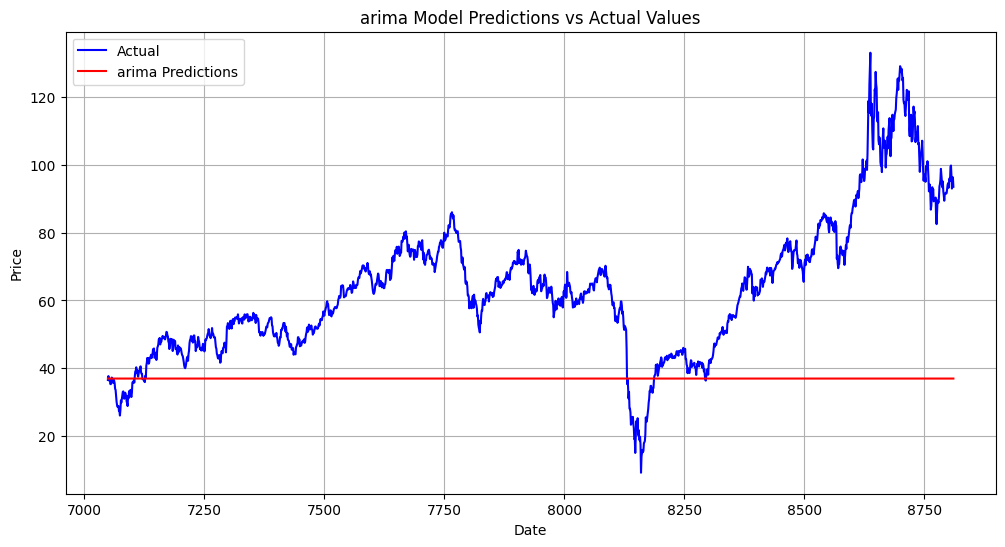

In [7]:
# ARIMA Model
print("Fitting ARIMA model...")
analyzer.fit_arima(order=(1,1,1))  # You can adjust the order parameters
print("ARIMA metrics:", analyzer.metrics.get('arima', 'Not available'))
analyzer.plot_results('arima')

In [8]:
# GARCH Model
print("\nFitting GARCH model...")
analyzer.fit_garch(vol_order=(1,1))  # You can adjust the volatility order
print("GARCH metrics:", analyzer.metrics.get('garch', 'Not available'))


Fitting GARCH model...
GARCH metrics: {'rmse': np.float64(0.03346001391515873), 'mae': np.float64(0.02512716056357726), 'r2': -1.2932085655217112}



Fitting VAR model...
Error calculating metrics for var: y_true and y_pred have different number of output (1!=4)
VAR metrics: Not available


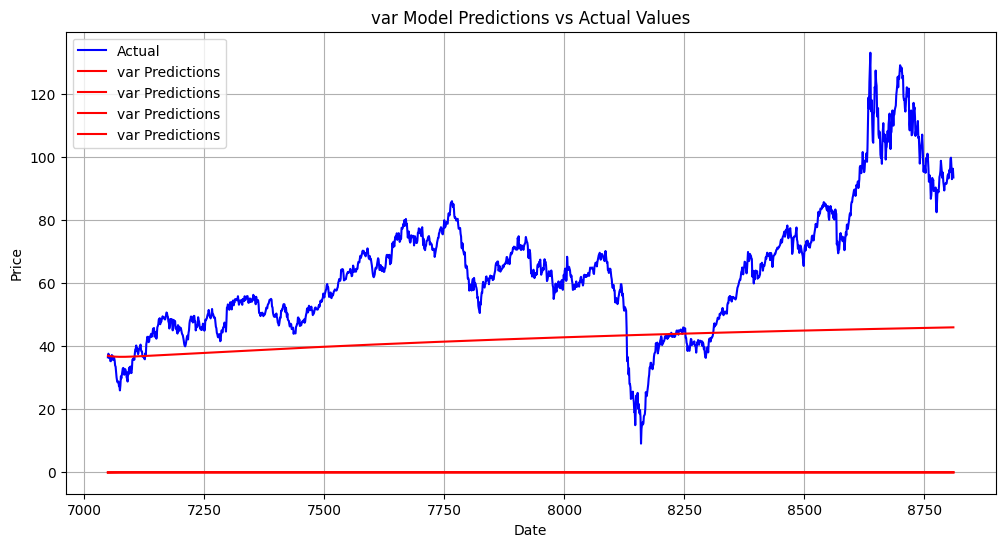

In [9]:
# VAR Model
print("\nFitting VAR model...")
analyzer.fit_var(maxlags=5)  # You can adjust the maximum lags
print("VAR metrics:", analyzer.metrics.get('var', 'Not available'))
analyzer.plot_results('var')


Fitting LSTM model...
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM metrics: {'rmse': np.float64(3.0230494232463463), 'mae': np.float64(2.343354815327974), 'r2': 0.9776502424862403}


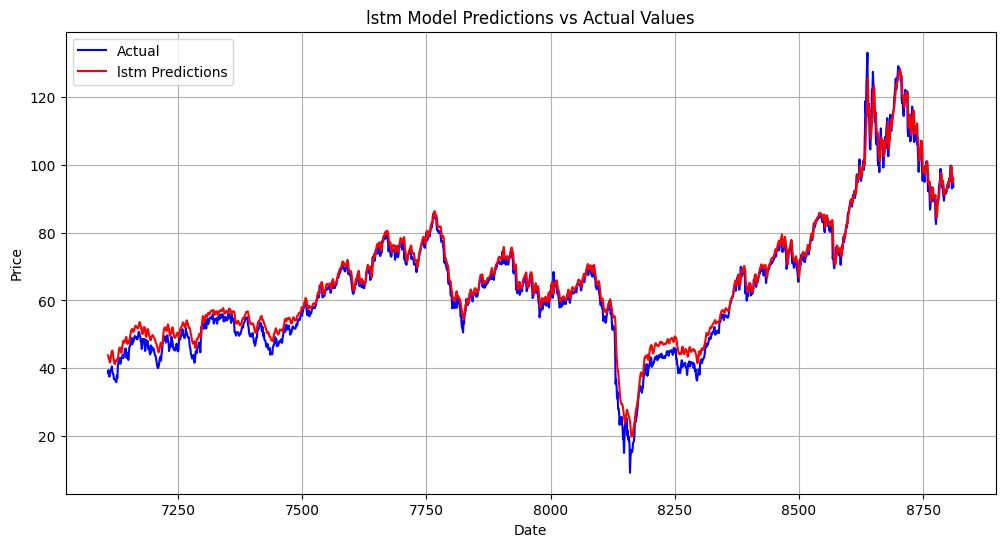

In [10]:
# LSTM Model
print("\nFitting LSTM model...")
lstm_history = analyzer.fit_lstm(
    seq_length=60,  # Number of time steps to look back
    epochs=100,     # Number of training epochs
    batch_size=32   # Batch size for training
)
print("LSTM metrics:", analyzer.metrics.get('lstm', 'Not available'))
analyzer.plot_results('lstm')

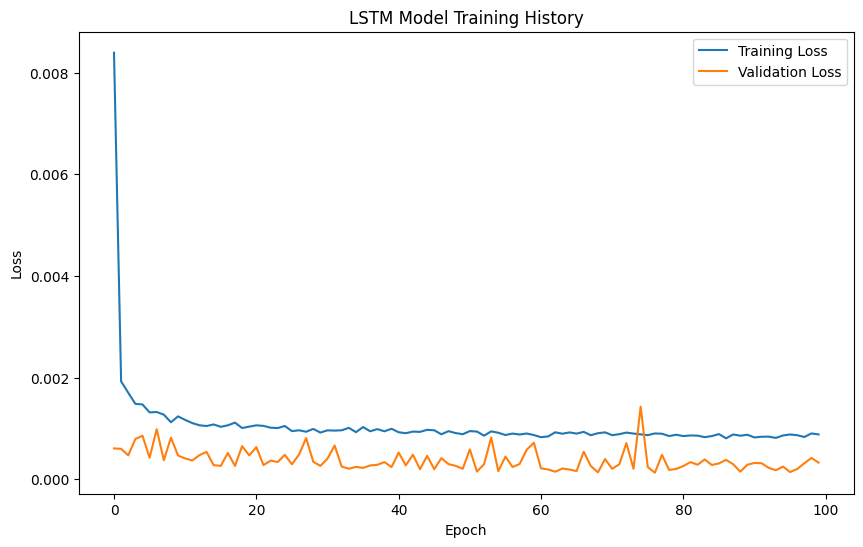

In [11]:
# Plot LSTM training history
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Perform cross-validation for LSTM
print("\nPerforming cross-validation for LSTM...")
cv_mean, cv_std = analyzer.cross_validate('lstm', n_splits=5)
print(f"Cross-validation RMSE: {cv_mean:.4f} (+/- {cv_std:.4f})")


Performing cross-validation for LSTM...
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Cross-validation RMSE: 0.0208 (+/- 0.0167)


In [13]:
# Compare all models
print("\nComparison of all models:")
metrics_df = pd.DataFrame.from_dict(analyzer.metrics, orient='index')
print(metrics_df)


Comparison of all models:
            rmse        mae        r2
arima  33.453638  27.347140 -1.620714
garch   0.033460   0.025127 -1.293209
lstm    3.023049   2.343355  0.977650


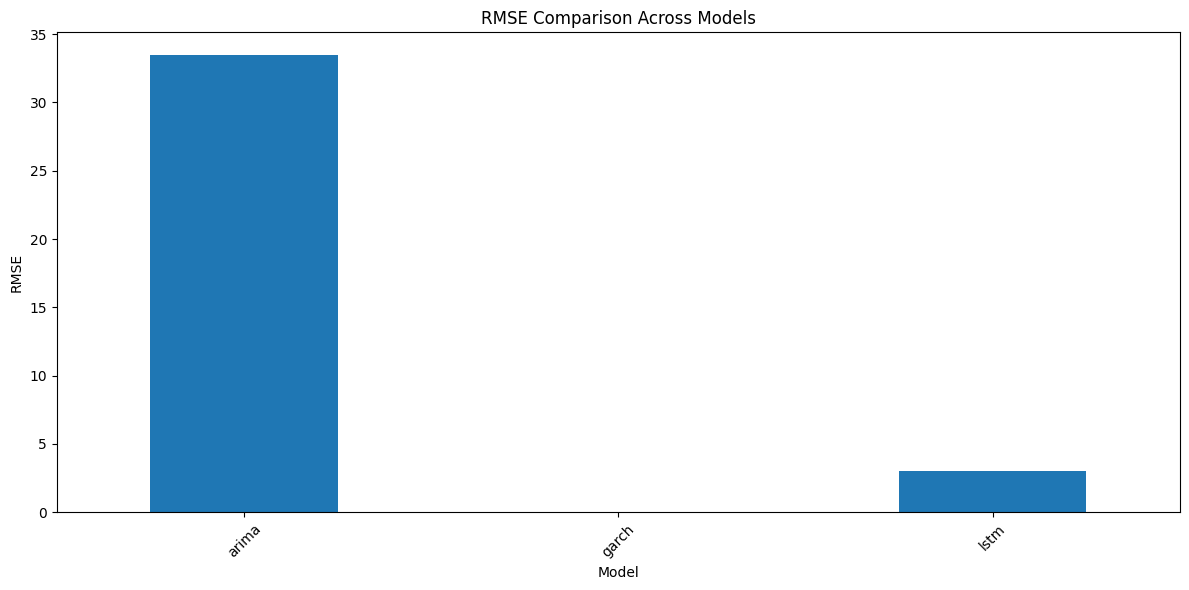

In [17]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
metrics_df['rmse'].plot(kind='bar')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Integrate external data if you have any
"""
# Example of integrating external data:
external_data = pd.DataFrame({
    'gdp': [...],
    'inflation': [...],
    'oil_production': [...]
}, index=df.index)

analyzer.integrate_external_data(external_data)
"""

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Actual': analyzer.test['Price'],
    'ARIMA': analyzer.predictions.get('arima', np.nan),
    'VAR': analyzer.predictions.get('var', np.nan)['Price'] if isinstance(analyzer.predictions.get('var', np.nan), pd.DataFrame) else np.nan,
    'LSTM': analyzer.predictions.get('lstm', np.nan).flatten()
})
predictions_df.to_csv('model_predictions.csv')

In [18]:
# Create a summary report
print("\nModel Performance Summary:")
print("-" * 50)
for model_name, metrics in analyzer.metrics.items():
    print(f"\n{model_name.upper()} Model:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")


Model Performance Summary:
--------------------------------------------------

ARIMA Model:
RMSE: 33.4536
MAE: 27.3471
R²: -1.6207

GARCH Model:
RMSE: 0.0335
MAE: 0.0251
R²: -1.2932

LSTM Model:
RMSE: 3.0230
MAE: 2.3434
R²: 0.9777
